In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download jessicali9530/celeba-dataset
! unzip celeba-dataset.zip

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
root_directory = "/content/"
img_directory = "img_align_celeba/img_align_celeba/"
df = pd.read_csv(root_directory+"list_attr_celeba.csv")
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


For now, we'll only predict the gender of a person based on an image.

In [7]:
df = df[["image_id","Male"]]
df.replace(to_replace=[-1,1],value=["Female","Male"],inplace=True)
df.rename(columns={"Male":"gender"},inplace=True)
df.head()

<ipython-input-7-89a06435b98f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(to_replace=[-1,1],value=["Female","Male"],inplace=True)
<ipython-input-7-89a06435b98f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"Male":"gender"},inplace=True)


,image_id,gender
0,000001.jpg,Female
1,000002.jpg,Female
2,000003.jpg,Male
3,000004.jpg,Female
4,000005.jpg,Female


We visualise the data distribution

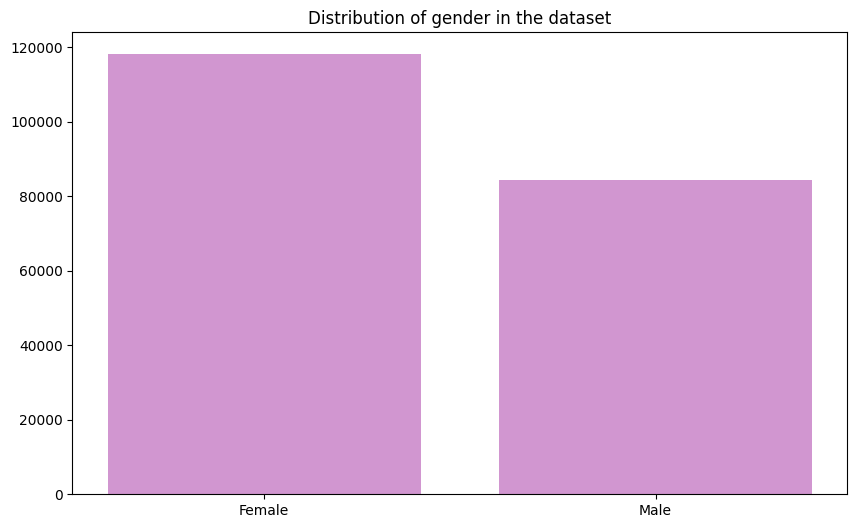

In [8]:
classes,counts=np.unique(df["gender"],return_counts=True)

plt.figure(figsize=(10,6))
plt.bar(classes,counts,color="#D196D0")
plt.title("Distribution of gender in the dataset")
plt.show()

We prepare a training and testing set.

In [9]:
df_train, df_test = train_test_split(df,test_size=0.1)
print(df_train.shape)
print(df_test.shape)

(182339, 2)
(20260, 2)


We generate augmented images for the training set.

In [10]:
img_size = (128,128)
batch_size = 128
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                  vertical_flip=True,
                                  rotation_range=180,
                                  shear_range=10,
                                  zoom_range=0.2,
                                  validation_split=0.2)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(directory=root_directory+img_directory,
                                                   dataframe=df_train,
                                                   x_col="image_id",
                                                   y_col="gender",
                                                   subset="training",
                                                   batch_size=batch_size,
                                                   target_size=img_size,
                                                   shuffle=True,
                                                   class_mode="binary")

val_generator = train_datagen.flow_from_dataframe(directory=root_directory+img_directory,
                                                   dataframe=df_train,
                                                   x_col="image_id",
                                                   y_col="gender",
                                                   subset="validation",
                                                   batch_size=batch_size,
                                                   target_size=img_size,
                                                   shuffle=True,
                                                   class_mode="binary")

test_generator = test_datagen.flow_from_dataframe(directory=root_directory+img_directory,
                                                   dataframe=df_test,
                                                   x_col="image_id",
                                                   y_col="gender",
                                                   batch_size=batch_size,
                                                   target_size=img_size,
                                                   shuffle=False,
                                                   class_mode="binary")

Found 145872 validated image filenames belonging to 2 classes.
Found 36467 validated image filenames belonging to 2 classes.
Found 20260 validated image filenames belonging to 2 classes.


We display some images

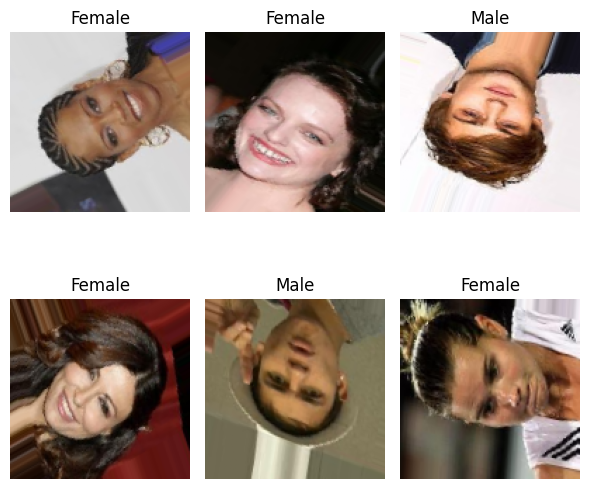

In [23]:
batch_data, batch_labels = train_generator.next()

n_rows = 2
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 6))

for i in range(n_rows):
    for j in range(n_cols):
        r = random.randint(0, len(batch_labels) - 1)

        axes[i, j].imshow(batch_data[r]/255)
        axes[i, j].set_title(classes[batch_labels.astype(int)[r]])
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

We create the model.

In [24]:
img_shape = img_size + tuple([3])
efficient_net = EfficientNetV2B0(
    weights='imagenet',
    input_shape=img_shape,
    include_top=False,
    pooling='max')

model = Sequential()
model.add(efficient_net)
model.add(layers.Dense(512,activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

24274472/24274472 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 6575697 (25.08 MB)
Trainable params: 6515089 (24.85 MB)
Non-trainable params: 60608 (236.75 KB)
_________________________________________________________________


In [25]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [26]:
nb_epochs = 1
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator,
    validation_steps = val_generator.samples // batch_size,
    epochs = nb_epochs)

1139/1139 [==============================] - 1081s 897ms/step - loss: 0.1511 - accuracy: 0.9474 - val_loss: 0.1037 - val_accuracy: 0.9607


We evaluate the model on the testing set

In [27]:
model.evaluate(test_generator)

159/159 [==============================] - 28s 174ms/step - loss: 0.1172 - accuracy: 0.9553


[0.11723016947507858, 0.9553307294845581]

We display the true values against the predictions

In [34]:
preds_raw = model.predict(test_generator)

159/159 [==============================] - 19s 119ms/step


In [36]:
preds = []
for pred in preds_raw:
  if pred > 0.5:
    preds.append(1)
  else:
    preds.append(0)

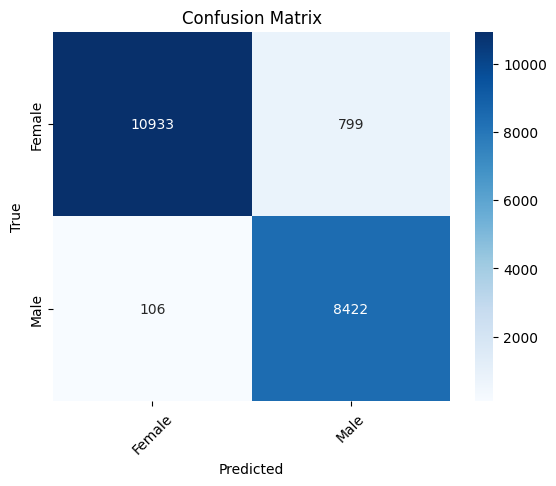

In [37]:
cm = confusion_matrix(test_generator.classes,preds)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

We save the model

In [38]:
from google.colab import drive
model.save("gender_classification_v0")
drive.mount('/content/drive')
!cp -r "gender_classification_v0" "/content/drive/MyDrive/"

Mounted at /content/drive
